# TimeEval parameter optimization result analysis of extra experiments

Extra experiments and their reason:

- PST: redo experiment with fixed parameter search space
- NumentaHTM: also optimize (previously) fixed parameters, because of bad performance
- ARIMA and DeepNAP: Were included in the algorithm set that should be optimized manually, but had very large runtimes. We decied to test some parameter ranges automatically instead.

In [1]:
# imports
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "test-cases"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-10-14_optim-extra"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/2021-10-14_optim-extra'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-17_optim-extra2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part6')]


Selecting:
Data path: /home/projects/akita/data/test-cases
Result path: /home/projects/akita/results/2021-10-14_optim-extra


Load results and dataset metadata:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# add dataset_name column
df["dataset_name"] = df["dataset"].str.split(".").str[0]

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-10-14_optim-extra


Remove wrongly configured experiments:

```
    algorithms.append(
        numenta_htm(params=FullParameterGrid({
            "n_trees": [10, 100, 200],
            "n_estimators": [10, 100, 200],
            "bootstrap": [True, False]
        }))
    )
```
 This parameter grid should have been applied to the _Random Black Forest (RR)_ algorithm. The executions on NumentaHTM are not meaningful!

In [4]:
drop_indices = (df["algorithm"] == "NumentaHTM") & (df["hyper_params"].apply(lambda x: any(v in x for v in ["n_estimators", "n_trees", "boostrap"])))
df = df[~drop_indices]

Extract target optimized parameter names that were iterated in this run (per algorithm):

In [5]:
algo_param_mapping = {}
algorithms = df["algorithm"].unique()
param_ignore_list = ["max_anomaly_window_size", "anomaly_window_size", "neighbourhood_size", "window_size", "n_init_train", "embed_dim_range"]

for algo in algorithms:
    param_sets = df.loc[df["algorithm"] == algo, "hyper_params"].unique()
    param_sets = [json.loads(ps) for ps in param_sets]
    param_names = np.unique([name for ps in param_sets for name in ps if name not in param_ignore_list])
    search_space = set()
    for param_name in param_names:
        values = []
        for ps in param_sets:
            try:
                values.append(ps[param_name])
            except:
                pass
        values = np.unique(values)
        if values.shape[0] > 1:
            search_space.add(param_name)
    algo_param_mapping[algo] = list(search_space)

for algo in algo_param_mapping:
    print(algo, algo_param_mapping[algo])

ARIMA ['differencing_degree']
DeepNAP ['partial_sequence_length', 'lstm_layers', 'rnn_hidden_size', 'linear_hidden_size']
PST ['sim']
NumentaHTM ['globalDecay', 'maxSynapsesPerSegment', 'maxSegmentsPerCell', 'potentialPct', 'alpha', 'synPermInactiveDec', 'initialPerm', 'columnCount', 'autoDetectWaitRecords', 'numActiveColumnsPerInhArea', 'encoding_output_width', 'pamLength', 'permanenceInc', 'encoding_input_width', 'synPermActiveInc', 'inputWidth', 'maxAge', 'synPermConnected', 'newSynapseCount', 'permanenceDec', 'cellsPerColumn', 'minThreshold', 'activationThreshold']


Extract optimized parameters and their values (columns: optim_param_name and optim_param_value) for each experiment:

In [6]:
def extract_hyper_params(algo):
    param_names = algo_param_mapping[algo]
    def extract(value):
        params = json.loads(value)
        result = None
        for name in param_names:
            try:
                value = params[name]
                result = pd.Series([name, value], index=["optim_param_name", "optim_param_value"])
                break
            except KeyError:
                pass
        if result is None:
            return pd.Series([np.nan, np.nan], index=["optim_param_name", "optim_param_value"])
        return result
    return extract

df[["optim_param_name", "optim_param_value"]] = ""
for algo in algo_param_mapping:
    df_algo = df.loc[df["algorithm"] == algo]
    df.loc[df_algo.index, ["optim_param_name", "optim_param_value"]] = df_algo["hyper_params"].apply(extract_hyper_params(algo))

Extract window size parameters (dependent params) and convert them into multiples of the dataset period size:

Define utility functions

In [7]:
def load_scores_df(algorithm_name, dataset_id, optim_params, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]) & (df["optim_param_name"] == optim_params[0]) & (df["optim_param_value"] == optim_params[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [8]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_name, use_plotly: bool = default_use_plotly, **kwargs):
    if isinstance(algorithm_name, tuple):
        algorithms = [algorithm_name]
    elif not isinstance(algorithm_name, list):
        raise ValueError("Please supply a tuple (algorithm_name, optim_param_name, optim_param_value) or a list thereof as first argument!")
    else:
        algorithms = algorithm_name
    # construct dataset ID
    dataset_id = ("GutenTAG", f"{dataset_name}.unsupervised")

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[df["dataset_name"] == dataset_name, "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo, optim_param_name, optim_param_value in algorithms:
        optim_params = f"{optim_param_name}={optim_param_value}"
        algos.append((algo, optim_params))
        # get algorithm metric results
        try:
            auroc[(algo, optim_params)] = df.loc[
                (df["algorithm"] == algo) & (df["dataset_name"] == dataset_name) & (df["optim_param_name"] == optim_param_name) & (df["optim_param_value"] == optim_param_value),
                "ROC_AUC"
            ].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} with params {optim_params} was not executed on {dataset_name}.")
            auroc[(algo, optim_params)] = -1
            skip_algos.append((algo, optim_params))
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[(algo, optim_params)] = load_scores_df(algo, ("GutenTAG", f"{dataset_name}.{training_type}"), (optim_param_name, optim_param_value)).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name} with params {optim_params}.")
            df_scores[(algo, optim_params)] = np.nan
            skip_algos.append((algo, optim_params))
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=f"channel-{i}"), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for item in algorithms:
        algo, optim_params = item
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[item], name=f"{algo}={auroc[item]:.4f} ({optim_params})"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=f"channel-{i}")
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for item in algorithms:
        algo, optim_params = item
        axs[1].plot(df_scores.index, df_scores[item], label=f"{algo}={auroc[item]:.4f} ({optim_params})")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}")
    fig.tight_layout()
    return fig

## Parameter assessment

In [9]:
sort_by = ("ROC_AUC", "mean")
metric_agg_type = ["min", "mean", "median"]
time_agg_type = "mean"
aggs = {
    "PR_AUC": metric_agg_type,
    "ROC_AUC": metric_agg_type,
    "train_main_time": time_agg_type,
    "execute_main_time": time_agg_type,
    "repetition": "count"
}

df_tmp = df.reset_index()
df_tmp = df_tmp.groupby(by=["algorithm", "optim_param_name", "optim_param_value"]).agg(aggs)
df_tmp = df_tmp.reset_index()
df_tmp = df_tmp.sort_values(by=["algorithm", "optim_param_name", sort_by], ascending=False)
df_tmp = df_tmp.set_index(["algorithm", "optim_param_name", "optim_param_value"])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_tmp)

PR_AUC            \
                                                              min      mean   
algorithm  optim_param_name           optim_param_value                       
PST        sim                        simn               0.000050  0.338418   
                                      simo               0.000050  0.339220   
NumentaHTM synPermInactiveDec         0.01               0.000500  0.100046   
                                      0.005              0.000500  0.097278   
                                      0.001              0.000500  0.097582   
           synPermConnected           0.1                0.000500  0.097278   
                                      0.2                0.000500  0.100681   
                                      0.05                    NaN       NaN   
           synPermActiveInc           0.05               0.000500  0.103190   
                                      0.1                0.000500  0.097278   
                                      0.2                     NaN       NaN   
           potentialPct               0.1                0.000500  0.076253   
                                      0.5                0.000500  0.097278   
                                      0.9                0.000500  0.079891   
           permanenceInc              0.05               0.000500  0.100419   
                                      0.1                0.000500  0.097278   
                                      0.2                0.000500  0.095074   
           permanenceDec              0.1                0.000500  0.097278   
                                      0.2                0.000500  0.096756   
                                      0.05               0.000500  0.096898   
           pamLength                  1                  0.000500  0.097278   
                                      5                  0.000500  0.095681   
                                      3                  0.000500  0.097651   
           numActiveColumnsPerInhArea 50.0               0.000500  0.101024   
                                      30.0               0.000500  0.106062   
                                      40.0               0.000500  0.097278   
           newSynapseCount            15.0               0.000500  0.097521   
                                      20.0               0.000500  0.097278   
                                      30.0               0.000500  0.096892   
           minThreshold               9.0                0.000500  0.097278   
                                      6.0                0.000500  0.097300   
                                      12.0               0.000500  0.095512   
           maxSynapsesPerSegment      32.0               0.000500  0.097278   
                                      64.0               0.000500  0.097227   
                                      16.0                    NaN       NaN   
           maxSegmentsPerCell         64.0               0.000500  0.097278   
                                      128.0              0.000500  0.097278   
                                      256.0              0.000500  0.097278   
           maxAge                     0                  0.000500  0.097278   
                                      5                       NaN       NaN   
                                      10                      NaN       NaN   
           inputWidth                 1024.0             0.000500  0.097278   
                                      2048.0             0.000500  0.097278   
                                      4096.0             0.000500  0.097278   
           initialPerm                0.15               0.000500  0.098333   
                                      0.21               0.000500  0.097278   
                                      0.3                0.000500  0.094185   
           globalDecay                0                  0.000500  0.097278   
                              

#### Selected parameters

- PST: `sim="SIMn"`
- NumentaHTM: 
  ```json
  "NumentaHTM": {
      "alpha": 0.5,  # no change
      "globalDecay": 0,  # only 0 works
      "encoding_output_width": 75,
      "encoding_input_width": 21,  # only 21 works
      "columnCount": 2048,  # no significant change; lower -> faster
      "cellsPerColumn": 32,  # no signifacnt change; lower -> faster
      "autoDetectWaitRecords": 50,  # no chnage
      "activationThreshold": 12,  # strange behavior, but no significant improvement over default
      "inputWidth": 2048,  # no change
      "initialPerm": 0.15,
      "maxAge": 0,  # only 0 works
      "synPermConnected": 0.1,  # only 0.1 and 0.2 works
      "synPermInactiveDec": 0.01,
      "synPermActiveInc": 0.05,
      "maxSegmentsPerCell": 128,  # no change
      "potentialPct": 0.1,
      "permanenceInc": 0.1,  # no significant change
      "permanenceDec": 0.1,  # no significant change
      "pamLength": 1,  # no significant change
      "numActiveColumnsPerInhArea": 50,
      "newSynapseCount": 15,
      "minThreshold": 9,  # no significant change
      "maxSynapsesPerSegment": 32  # only 32 and 64 works; no significant change
  }
  ```
- DeepNAP:
  ```json
  "DeepNAP": {
      "rnn_hidden_size": 200,
      "linear_hidden_size": 100,
      "partial_sequency_length": 1,
      "lstm_layers": 1
  }
  ```
  (lstm_layers: more are better, but quite a lot slower; linear_hidden_size: almost no difference, using default; partial_sequence_length: 10 is slightly better in mean ROC_AUC, but 1 is better in all other metrics and even faster)
- ARIMA: `differencing_degree=1`

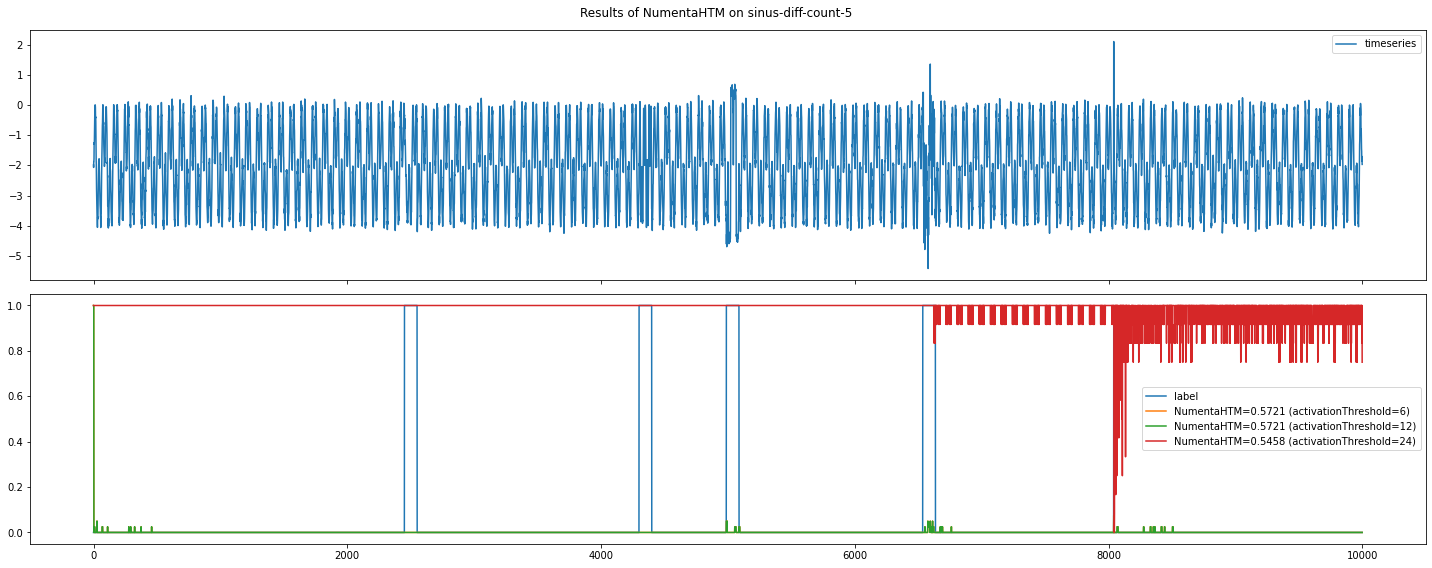

In [10]:
plot_scores([
    ("NumentaHTM", "activationThreshold", 6),
    ("NumentaHTM", "activationThreshold", 12),
    ("NumentaHTM", "activationThreshold", 24)
], "sinus-diff-count-5", use_plotly=False)
plt.show()

Failed runs

In [11]:
df[df["status"] != "Status.OK"].groupby(by=["algorithm", "optim_param_name", "optim_param_value", "status"])[["repetition"]].count()

repetition
algorithm  optim_param_name        optim_param_value status                    
ARIMA      differencing_degree     1.00              Status.TIMEOUT           2
                                   2.00              Status.ERROR             1
DeepNAP    linear_hidden_size      70.00             Status.ERROR           132
                                                     Status.TIMEOUT          56
                                   100.00            Status.ERROR           131
                                                     Status.TIMEOUT          57
                                   130.00            Status.ERROR           145
                                                     Status.TIMEOUT          43
           lstm_layers             1.00              Status.ERROR            29
                                                     Status.TIMEOUT          12
                                   3.00              Status.ERROR            20
                                                     Status.TIMEOUT         169
                                   10.00             Status.ERROR            27
                                                     Status.TIMEOUT         166
           partial_sequence_length 1.00              Status.ERROR           128
                                                     Status.TIMEOUT          48
                                   3.00              Status.ERROR           138
                                                     Status.TIMEOUT          50
                                   5.00              Status.ERROR           138
                                                     Status.TIMEOUT          50
                                   10.00             Status.ERROR           134
                                                     Status.TIMEOUT          54
           rnn_hidden_size         140.00            Status.ERROR           133
                                                     Status.TIMEOUT          52
                                   200.00            Status.ERROR           128
                                                     Status.TIMEOUT          60
                                   260.00            Status.ERROR           132
                                                     Status.TIMEOUT          56
NumentaHTM encoding_input_width    15.00             Status.ERROR           168
                                   30.00             Status.ERROR           168
           globalDecay             0.10              Status.ERROR           168
                                   0.50              Status.ERROR           168
           maxAge                  5.00              Status.ERROR           168
                                   10.00             Status.ERROR           168
           maxSynapsesPerSegment   16.00             Status.ERROR           168
           synPermActiveInc        0.20              Status.ERROR           168
           synPermConnected        0.05              Status.ERROR           168